## Скачивание файлов

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
import os

In [98]:
base = "http://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/"
paths = {
    "E_billingiae": "000/196/615/GCF_000196615.1_ASM19661v1",
    "E_gerundensis": "020/342/335/GCF_020342335.1_ASM2034233v1",
    "E_persicina": "019/844/095/GCF_019844095.1_ASM1984409v1",
    "E_pyrifoliae": "002/952/315/GCF_002952315.1_ASM295231v1",
    "E_tasmaniensis": "000/026/185/GCF_000026185.1_ASM2618v1"
}
genomic_end = "_genomic.fna.gz"
feature_end = "_feature_table.txt.gz"
protein_end = "_protein.faa.gz"

! mkdir -p genomes histograms zhunt_result TSS intersect ortho clusters/raw clusters/aligned pictures

In [ ]:
for key in paths.keys():
    os.system(f"wget -c -nv {base}{paths[key]}/{paths[key].split('/')[-1]}{genomic_end} -O 'genomes/{key}{genomic_end}'")
    os.system(f"wget -c -nv {base}{paths[key]}/{paths[key].split('/')[-1]}{feature_end} -O 'genomes/{key}{feature_end}'")
    os.system(f"gzip -f -d genomes/{key}{genomic_end}")
    os.system(f"gzip -f -d genomes/{key}{feature_end}")

In [ ]:
for key in paths.keys():
    os.system(f"wget -c -nv {base}{paths[key]}/{paths[key].split('/')[-1]}{protein_end} -O 'genomes/{key}{protein_end}'")
    os.system(f"gzip -f -d genomes/{key}{protein_end}")

## Анализ аннотированных геномов

In [3]:
genomes_list = list(paths.keys())

In [4]:
def annot_analyse(genome):
    features = pd.read_csv(f"genomes/{genome}_feature_table.txt", sep='\t')
    features = features.loc[
        (features['# feature']=='gene') & 
        (features['seq_type']=='chromosome')
    ]
    seqs = [len(seq_record.seq) for seq_record in SeqIO.parse(f"genomes/{genome}_genomic.fna", "fasta")]
    # Choose complete genome, remove plasmids
    genome_len = max(seqs)

    total_genes_len = features["feature_interval_length"].sum()

    return [len(features), round(total_genes_len/genome_len*100, 2), genome_len]


In [73]:
annot_dict = dict()
for genome in genomes_list:
    annot_dict[genome] = annot_analyse(genome)

pd.DataFrame(annot_dict, index=["Genes number", "Genome coverage", "Genome length"])

,E_billingiae,E_gerundensis,E_persicina,E_pyrifoliae,E_tasmaniensis
Genes number,4703.00,3458.00,4311.00,3746.00,3569.00
Genome coverage,88.99,88.19,88.61,86.27,86.71
Genome length,5100167.00,3748909.00,4664605.00,4027225.00,3883467.00


## Предсказание участков Z-DNA

In [ ]:
os.system("wget -c -nv https://raw.githubusercontent.com/vanya-antonov/hse22-project/main/zhunt3-alan.c")

In [ ]:
os.system("gcc zhunt3-alan.c -lm -o zhunt3")

In [7]:
import os
import subprocess
import tempfile
from pathlib import Path
from subprocess import DEVNULL, PIPE

ZH_EXECUTABLE = Path("../hse22_project/zhunt3")
assert ZH_EXECUTABLE.is_file()


def zhunt(query: str, windowsize: int = 6, minsize: int = 3, maxsize: int = 6):
    assert set(query).issubset({"A", "C", "G", "T", "N"})
    fd, temp = tempfile.mkstemp()
    os.close(fd)
    with open(temp, 'w') as stream:
        stream.write(query)

    subprocess.run(
        [ZH_EXECUTABLE, 
         str(windowsize), str(minsize), str(maxsize), temp],
        check=True, stdout=PIPE, stderr=DEVNULL,
        input=query, encoding='ascii'
    )
    with open(temp + ".Z-SCORE", 'r') as stream:
        df = pd.read_csv(stream,
                         names=['Start', 'End', 'nu-1', 'nu-2', 'nu-3', 
                                'ZH-Score', 'Sequence', 'Conformation'],
                         skiprows=1, sep='\s+')
    os.remove(temp)
    os.remove(temp + ".Z-SCORE")
    df = df.loc[df["ZH-Score"] > 500]
    return df[['Start', 'End', 'ZH-Score', 'Sequence', 'Conformation']]

In [8]:
def choose_max_seq(genome):
    seqs = [str(seq_record.seq) for seq_record in SeqIO.parse(f"genomes/{genome}_genomic.fna", "fasta")]
    # Choose complete genome, remove plasmids
    max_scaffold = max(seqs, key=len)
    return max_scaffold

In [9]:
zhunt_dict = dict()
for genome in genomes_list:
    zhunt_dict[genome] = zhunt(choose_max_seq(genome))

In [67]:
zhunt_dict[genomes_list[0]]

,Start,End,ZH-Score,Sequence,Conformation
733,734,742,766.6232,cgtgcgtg,ASASASAS
1677,1678,1690,1356.2120,gggcgtgcccgc,SASASASASASA
1679,1680,1690,1201.6710,gcgtgcccgc,SASASASASA
1744,1745,1753,516.0707,ttgcgcgc,SASASASA
1746,1747,1753,883.5764,gcgcgc,SASASA
...,...,...,...,...,...
5096951,5096952,5096962,2183.5740,cgtgcgtgtg,ASASASASAS
5097858,5097859,5097871,717.9641,aagcgtatgcgc,SASASASASASA
5097860,5097861,5097871,948.8341,gcgtatgcgc,SASASASASA
5098505,5098506,5098512,883.5764,gcgcgc,SASASA


In [68]:
def process_zhunt_data(df):
    df = df.sort_values(["End", "Start"], ascending=True)

    # Count length with overlapping positions
    pos = 0
    length = 0
    for i, row in df.iterrows():
        if row.Start > pos:
            length += row.End - row.Start + 1
            pos = row.End
        elif row.Start < pos and row.End > pos:
            length += row.End - pos + 1
            pos = row.End
    
    return [len(df), length]

In [69]:
zhunt_stats = dict()
for genome in genomes_list:
    zhunt_stats[genome] = process_zhunt_data(zhunt_dict[genome])

pd.DataFrame(zhunt_stats, index=["Number of Z-DNA regions (with overlaps)", "Z-DNA length"])

,E_billingiae,E_gerundensis,E_persicina,E_pyrifoliae,E_tasmaniensis
Number of Z-DNA regions (with overlaps),29749,33366,25907,25346,26301
Z-DNA length,119602,131756,107026,102084,103424


### Рисуем гистограммы

In [90]:
sns.set_theme()
for genome in genomes_list:
    sns.histplot(data=zhunt_dict[genome], x="ZH-Score", bins=30, log_scale=True)
    plt.title(genome.replace('_', '. ')+" ZH-Scores")
    plt.savefig(f"histograms/{genome}.png", dpi=400)
    plt.close()

### Сохраняем данные и создаём .bed файлы

In [105]:
for genome in genomes_list:
    zhunt_dict[genome].to_csv(f"zhunt_result/{genome}.zhunt.txt", index=None)

In [88]:
for genome in genomes_list:
    df = zhunt_dict[genomes_list[0]].copy()
    bed_df = pd.DataFrame(
        {
            "chrom": [genome] * len(df),
            "chromStart": df.Start,
            "chromEnd": df.End,
            "name": df.index,
            "score": df["ZH-Score"]
        }
    )

    bed_df.to_csv(f"zhunt_result/{genome}.zhunt.bed", index=None, sep='\t')


### Объединяем пересечения

In [89]:
for genome in genomes_list:
    os.system(f"bedtools merge -c 5 -o max -i zhunt_result/{genome}.zhunt.bed > zhunt_result/{genome}.zhunt.merged.bed")

## Ассоциируем предсказанные участки Z-DNA с промоторами генов

In [ ]:
features_dict = dict()

for genome in genomes_list:
    features = pd.read_csv(f"genomes/{genome}_feature_table.txt", sep='\t')
    features = features.loc[
        (features['seq_type']=='chromosome')
    ]
    locuses = list(np.unique(features.locus_tag))
    df = features.copy()

    counter = 1
    for locus in locuses:
        prod = list(features['product_accession'].loc[features.locus_tag == locus].dropna())
        if prod == []:
            prod = ["RNA" + str(counter)]
            counter += 1
            df['product_accession'].loc[df.locus_tag == locus] = prod[0]
        elif len(prod) == 1:
            df['product_accession'].loc[df.locus_tag == locus] = prod[0]
        else:
            print(prod)
    df = df.loc[df['# feature'] == 'gene']
    df = df[["# feature", "class" , "start", "end", "strand", "product_accession", "locus_tag"]]
    features_dict[genome] = df

In [49]:
for genome in genomes_list:
    features_dict[genome]['TSS'] = features_dict[genome].apply(lambda x: x.start if x.strand == "+" else x.end, axis=1)

In [108]:
for genome in genomes_list:
    df = features_dict[genome].copy()
    bed_df = pd.DataFrame(
        {
            "chrom": [genome] * len(df),
            "chromStart": df.TSS,
            "chromEnd": df.TSS,
            "name": df.product_accession
        }
    )

    bed_df.to_csv(f"TSS/{genome}.bed", index=None, header=None, sep='\t')

In [109]:
pd.DataFrame(
    {
        "Species": genomes_list,
        "Len": [annot_dict[genome][2] for genome in genomes_list]
    }
).to_csv(f"TSS/my.genomes", index=None, header=None, sep='\t')

In [110]:
for genome in genomes_list:
    os.system(f"bedtools slop -g TSS/my.genomes -i TSS/{genome}.bed -b 100 > TSS/{genome}.slop.bed")
    os.system(f"bedtools intersect -a TSS/{genome}.slop.bed -b zhunt_result/{genome}.zhunt.merged.bed -wb > intersect/{genome}.inter.bed")

## Создаём кластеры

In [ ]:
!sudo apt install proteinortho

In [117]:
!proteinortho -project=erwinia genomes/*faa
!mv erwinia* ortho/

*****************************************************************
Proteinortho with PoFF version 6.0.14 - An orthology detection tool
*****************************************************************
Detected 8 available CPU threads (adjust this with -cpus), Detected 'diamond' version 0.9.30
Checking input files.
Checking genomes/E_billingiae_protein.faa... ok
Checking genomes/E_gerundensis_protein.faa... ok
Checking genomes/E_persicina_protein.faa... ok
Checking genomes/E_pyrifoliae_protein.faa... ok
Checking genomes/E_tasmaniensis_protein.faa... ok

**Step 1**
Generating indices.
The database for 'genomes/E_billingiae_protein.faa' is present and will be used
The database for 'genomes/E_persicina_protein.faa' is present and will be used
The database for 'genomes/E_gerundensis_protein.faa' is present and will be used
The database for 'genomes/E_tasmaniensis_protein.faa' is present and will be used
The database for 'genomes/E_pyrifoliae_protein.faa' is present and will be used

**Step 2

### Пересекаем кластеры и Z-DNA

In [5]:
clusters = pd.read_csv("ortho/erwinia.proteinortho.tsv", sep='\t')
clusters = clusters.loc[clusters['# Species']==5]
clusters.sort_values("Alg.-Conn.", ascending=False, inplace=True)
clusters.reset_index(drop=True, inplace=True)
clusters.head(5)

,# Species,Genes,Alg.-Conn.,E_billingiae_protein.faa,E_gerundensis_protein.faa,E_persicina_protein.faa,E_pyrifoliae_protein.faa,E_tasmaniensis_protein.faa
0,5,5,0.982,WP_013204225.1,WP_067427185.1,WP_222681877.1,WP_015899125.1,WP_012442922.1
1,5,5,0.981,WP_173363027.1,WP_067429596.1,WP_174522410.1,WP_104945051.1,WP_012441756.1
2,5,5,0.981,WP_013201311.1,WP_225700887.1,WP_062748436.1,WP_012668725.1,WP_012442032.1
3,5,5,0.981,WP_013200102.1,WP_067426621.1,WP_062746920.1,WP_012666468.1,WP_012439841.1
4,5,5,0.981,WP_013203471.1,WP_067433095.1,WP_245006712.1,WP_012667256.1,WP_193345526.1


In [40]:
def read_zdna_df(genome):
    zdna = pd.read_csv(f"intersect/{genome}.inter.bed", sep='\t', 
                names=["Sp1", "St1", "En1", "Protein", "Sp2", "Start", "End", f"Score_{genome}"]
                )[["Protein", f"Score_{genome}", "Start", "End"]]
    zdna.sort_values(f"Score_{genome}", ascending=False, inplace=True)
    # Drop duplicate proteins, keep maximal score
    zdna.drop_duplicates(subset='Protein', inplace=True)
    zdna.set_index("Protein", inplace=True)
    return zdna

In [42]:
for genome in genomes_list:
    zdna = read_zdna_df(genome)[f"Score_{genome}"]
    list_of_zhscores = [float(zdna.loc[prot]) if prot in list(zdna.index) else None for prot in clusters[f"{genome}_protein.faa"]]
    clusters[f"{genome}_protein.score"] = list_of_zhscores
clusters.head()

,# Species,Genes,Alg.-Conn.,E_billingiae_protein.faa,E_gerundensis_protein.faa,E_persicina_protein.faa,E_pyrifoliae_protein.faa,E_tasmaniensis_protein.faa,E_billingiae_protein.score,E_gerundensis_protein.score,E_persicina_protein.score,E_pyrifoliae_protein.score,E_tasmaniensis_protein.score
0,5,5,0.982,WP_013204225.1,WP_067427185.1,WP_222681877.1,WP_015899125.1,WP_012442922.1,NaN,NaN,860.1321,NaN,NaN
1,5,5,0.981,WP_173363027.1,WP_067429596.1,WP_174522410.1,WP_104945051.1,WP_012441756.1,NaN,NaN,731.2843,883.5764,3428.529
2,5,5,0.981,WP_013201311.1,WP_225700887.1,WP_062748436.1,WP_012668725.1,WP_012442032.1,908.3955,NaN,3428.5290,NaN,NaN
3,5,5,0.981,WP_013200102.1,WP_067426621.1,WP_062746920.1,WP_012666468.1,WP_012439841.1,NaN,NaN,NaN,NaN,NaN
4,5,5,0.981,WP_013203471.1,WP_067433095.1,WP_245006712.1,WP_012667256.1,WP_193345526.1,NaN,NaN,NaN,650.9198,NaN


In [43]:
chosen = clusters.dropna(subset=clusters.columns[-5:])
chosen

,# Species,Genes,Alg.-Conn.,E_billingiae_protein.faa,E_gerundensis_protein.faa,E_persicina_protein.faa,E_pyrifoliae_protein.faa,E_tasmaniensis_protein.faa,E_billingiae_protein.score,E_gerundensis_protein.score,E_persicina_protein.score,E_pyrifoliae_protein.score,E_tasmaniensis_protein.score
123,5,5,0.966,WP_013200370.1,WP_225701291.1,WP_062748290.1,WP_014539587.1,WP_012442783.1,883.5764,1915.4320,1264.1890,980.8116,2659.7900
132,5,5,0.965,WP_013203580.1,WP_067433293.1,WP_062744233.1,WP_012669090.1,WP_012442437.1,883.5764,818.2755,3428.5290,907.7149,663.3761
930,5,5,0.936,WP_013200783.1,WP_225700991.1,WP_062747223.1,WP_012667145.1,WP_012440562.1,3428.5290,826.8355,8697.4600,1323.0540,783.8230
990,5,5,0.934,WP_013201679.1,WP_067429626.1,WP_062743729.1,WP_012668438.1,WP_012441745.1,736.1451,3135.7890,13713.9900,13713.9900,883.5764
1067,5,5,0.932,WP_013203485.1,WP_003849035.1,WP_062744160.1,WP_004155938.1,WP_012442362.1,1737.6120,783.8230,980.8116,883.5764,13713.9900
1544,5,5,0.905,WP_013202442.1,WP_225701617.1,WP_062746141.1,WP_014538862.1,WP_012441295.1,883.5764,980.8116,6970.7950,2752.4470,883.5764
1845,5,5,0.855,WP_013202465.1,WP_225701614.1,WP_222682263.1,WP_012667919.1,WP_012441270.1,883.5764,915.9191,783.8230,2752.4470,883.5764
1879,5,5,0.843,WP_013200831.1,WP_209500512.1,WP_191927791.1,WP_012667211.1,WP_012440626.1,766.6232,38833.5800,766.6232,904.3200,8782.1570


### Выравниваем белки

In [18]:
aa_seqs = dict()
for genome in genomes_list:
    aa_seqs[genome] = SeqIO.to_dict(SeqIO.parse(f"genomes/{genome}_protein.faa", "fasta"))


In [27]:
counter = 1

for i, row in chosen.iterrows():
    seqs_in_cluster = []
    for genome in genomes_list:
        protein_id = row[f"{genome}_protein.faa"]
        seqs_in_cluster.append(aa_seqs[genome][protein_id])
    SeqIO.write(seqs_in_cluster, f"clusters/raw/cluster_{counter}.faa", "fasta")
    counter += 1

In [29]:
! sudo apt install clustalw

[sudo] password for narek: 


In [ ]:
for cl in range(1,9):
    os.system(f"clustalw -align -type=PROTEIN -infile='clusters/raw/cluster_{cl}.faa' -OUTFILE='clusters/aligned/cluster_{cl}.aln'")

### Визуализируем

In [62]:
from dna_features_viewer import GraphicFeature, GraphicRecord

In [65]:
zdna_dict = dict()
for genome in genomes_list:
    features_dict[genome].set_index("product_accession", drop=False, inplace=True)
    zdna_dict[genome] = read_zdna_df(genome)

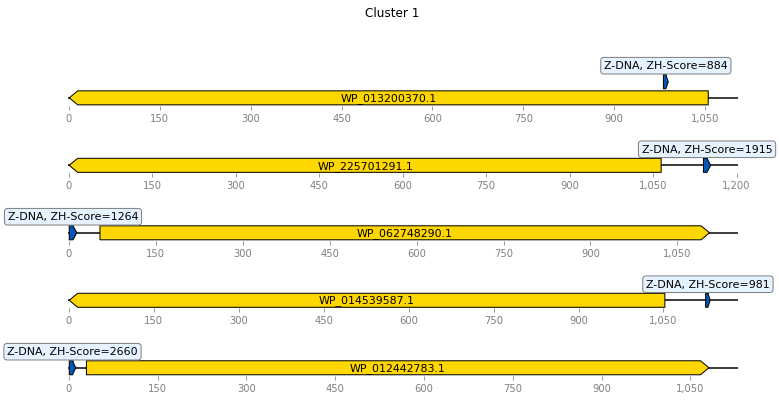

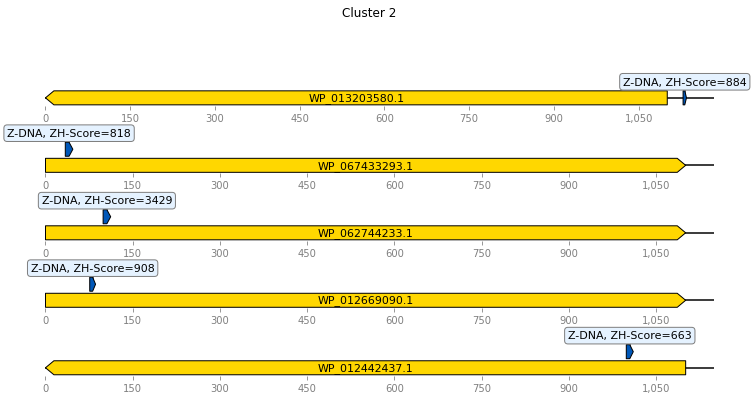

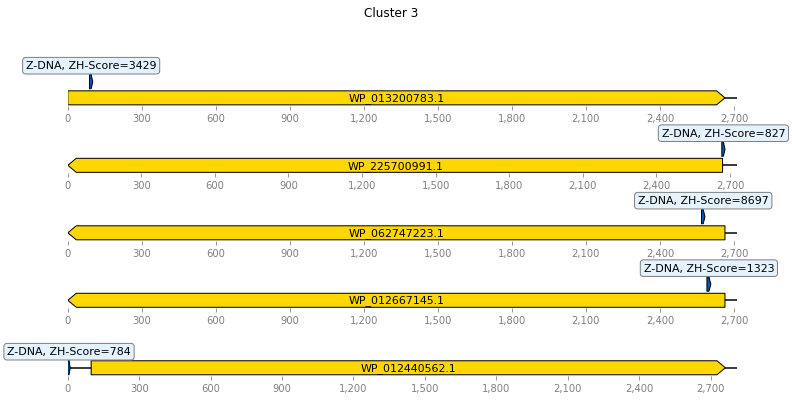

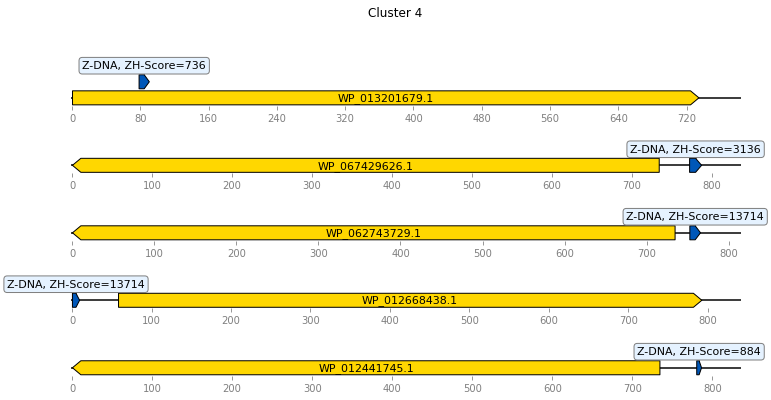

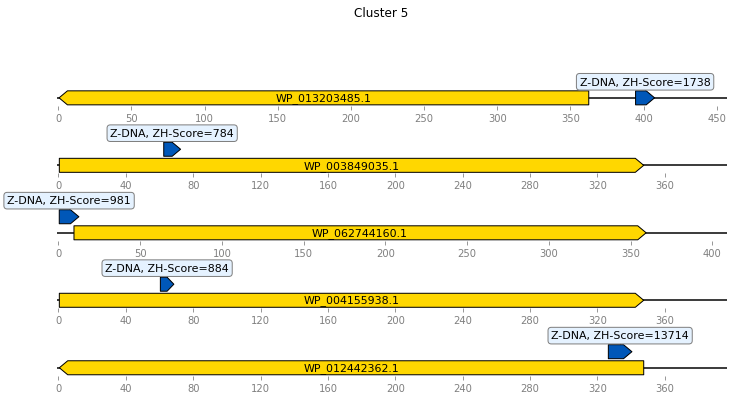

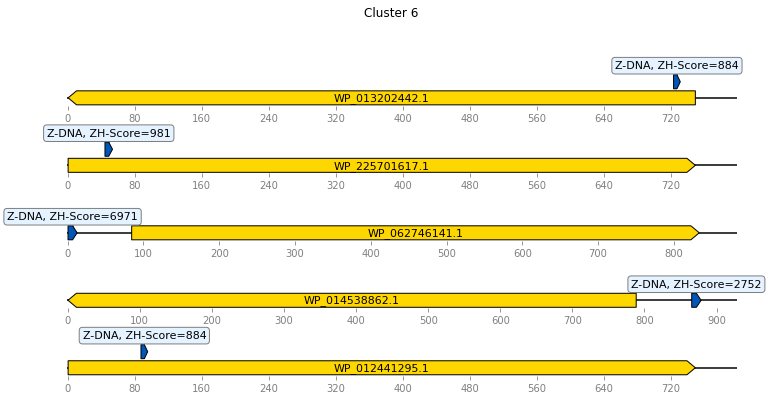

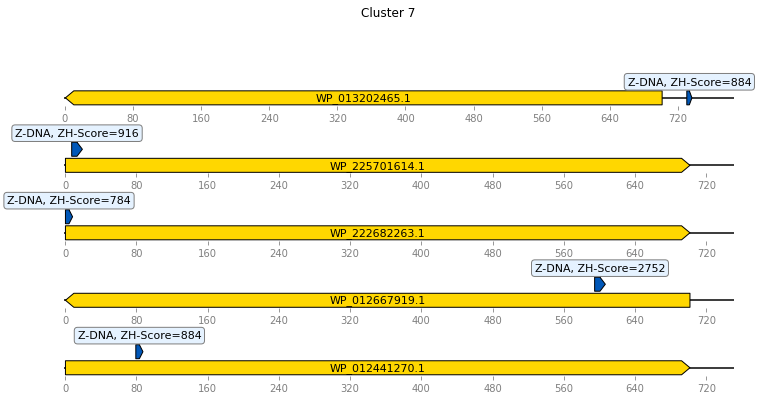

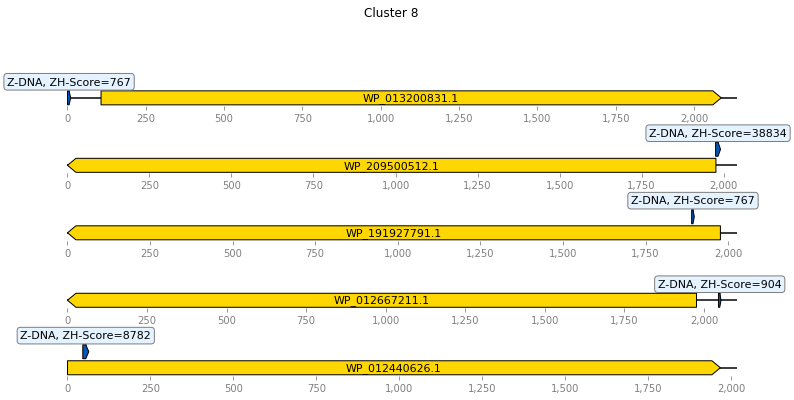

In [100]:
counter = 1
for i, row in chosen.iterrows():
    fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(12, 6))
    fig.suptitle(f'Cluster {counter}')

    for i, genome in enumerate(genomes_list):
        zdna = zdna_dict[genome]
        features = features_dict[genome]

        prot = row.loc[genome + '_protein.faa']
        Z_DNA_label = "Z-DNA, ZH-Score=" + str(round(zdna.loc[prot][f"Score_{genome}"]))
        coords = [zdna.loc[prot, "Start"], zdna.loc[prot, "End"],
                  features.loc[prot, "start"], features.loc[prot, "end"]]
        minimum = min(coords)

        strand = +1 if features.loc[prot, "strand"]=="+" else -1

        features=[
        GraphicFeature(start=coords[0]-minimum+1, end=coords[1]-minimum+1, 
                   strand=+1, color="#0057b8", label=Z_DNA_label),
        GraphicFeature(start=coords[2]-minimum+1, end=coords[3]-minimum+1, 
                   strand=strand, color="#ffd700", label=prot),
                   ]
        record = GraphicRecord(sequence_length=max(coords)-minimum+50, features=features)
        record.plot(ax=axes[i])
    plt.savefig(f'pictures/Cluster_{counter}.png', dpi=500)
    counter += 1